In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import mpmath as mp

In [2]:
# (slightly less) naive implementation
def msq1(p1, p2, m1, m2):
    m1_sq = m1 ** 2
    m2_sq = m2 ** 2
    
    # energies of particles 1 and 2
    e1 = np.sqrt(p1 ** 2 + m1_sq)
    e2 = np.sqrt(p2 ** 2 + m2_sq)

    # dangerous cancelation in third term
    return m1_sq + m2_sq + 2 * (e1 * e2 - p1 * p2)

In [3]:
@nb.njit
def unrolled_sort(a, b, c):
    # unrolled sort of three items
    if a < b:
        if c < b:
            if a < c:
                b, c = c, b
            else:
                t = a
                a = c
                c = b
                b = t
    else:
        if b < c:
            if a < c:
                a, b = b, a
            else:
                t = a
                a = b
                b = c
                c = t
        else:
            a, c = c, a
    return a, b, c


assert unrolled_sort(1, 2, 3) == (1, 2, 3)
assert unrolled_sort(1, 3, 2) == (1, 2, 3)
assert unrolled_sort(2, 1, 3) == (1, 2, 3)
assert unrolled_sort(2, 3, 1) == (1, 2, 3)
assert unrolled_sort(3, 1, 2) == (1, 2, 3)
assert unrolled_sort(3, 2, 1) == (1, 2, 3)

In [4]:
@nb.vectorize
def msq2(p1, p2, m1, m2):
    x1 = (m1 / p1) ** 2
    x2 = (m2 / p2) ** 2
    x = x1 + x2 + x1 * x2
    # sqrt(x + 1) - 1 = x / (sqrt(x + 1) + 1)
    y = 2 * p1 * p2 * x / (np.sqrt(1 + x) + 1)
    return m1 ** 2 + m2 ** 2 + y

    
@nb.vectorize
def msq3(p1, p2, m1, m2):
    x1 = (m1 / p1) ** 2
    x2 = (m2 / p2) ** 2
    x = sum(unrolled_sort(x1, x2, x1 * x2))
    # sqrt(x + 1) - 1 = x / (sqrt(x + 1) + 1)
    c = 2 * p1 * p2 * x / (np.sqrt(1 + x) + 1)
    return sum(unrolled_sort(m1 ** 2, m2 ** 2, c))

<ipython-input-5-26b26857b37f>:25: RuntimeWarning: invalid value encountered in msq3
  M = {f.__name__: f(p1.astype(np.float32),


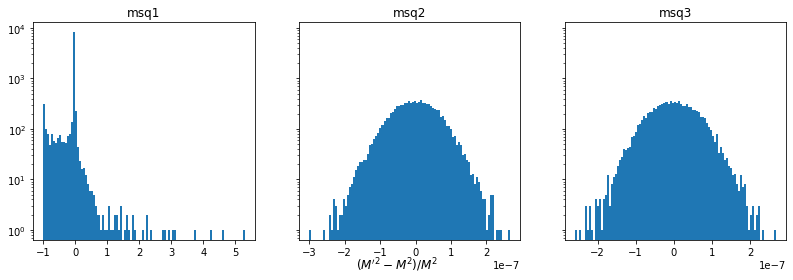

In [5]:
rng = np.random.default_rng(1)

p1 = 10 ** rng.uniform(0, 5, size=10000)
p2 = 10 ** rng.uniform(0, 5, size=10000)
m1 = 10 ** rng.uniform(-5, 5, size=10000)
m2 = 10 ** rng.uniform(-5, 5, size=10000)

# as reference we use naive formula computed with mpmath
M0 = []
with mp.workdps(100):
    for p1i, p2i, m1i, m2i in zip(p1, p2, m1, m2):        
        p1i = mp.mpf(p1i)
        p2i = mp.mpf(p2i)
        
        m1_sq = mp.mpf(m1i) ** 2
        m2_sq = mp.mpf(m2i) ** 2

        e1 = mp.sqrt(p1i ** 2 + m1_sq)
        e2 = mp.sqrt(p2i ** 2 + m2_sq)

        M0.append(m1_sq + m2_sq + 2 * (e1 * e2 - p1i * p2i))

M0 = np.array(M0, dtype=float)

M = {f.__name__: f(p1.astype(np.float32),
       p2.astype(np.float32),
       m1.astype(np.float32),
       m2.astype(np.float32)) for f in (msq1, msq2, msq3)}

fig, ax = plt.subplots(1, len(M), figsize=(len(M) * 4.5, 4), sharey=True)
for (fname, Mi), axi in zip(M.items(), ax):    
    axi.hist((Mi - M0) / M0, bins=100)
    axi.set_yscale("log")
    axi.set_title(fname)
fig.supxlabel(r"$(M'^2 - M^2) / M^2$");